**Predict the CO2 concentration of the Mount Lua Observatory using tensorflow probability time series modelling.**

[data source](https://www.esrl.noaa.gov/gmd/ccgg/trends/)

[reference](https://www.esrl.noaa.gov/gmd/ccgg/trends/)

---
In this notebook, we implement the structural time series model (STS) in tensorflow probability library to build up a model for analyzing the $CO_2$ concentration from the Mauna Loa observatory in Hawaii and producing a probabilistic forecast.  

We first import the original data and plot it.

In [135]:
%pylab inline
from numpy import genfromtxt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts
import tf_setCPU

Populating the interactive namespace from numpy and matplotlib


In [136]:
# read the co2 data
data = genfromtxt(fname="co2_mm_mlo.txt", comments='#')
dates = data[:,2]
averages = data[:,4]

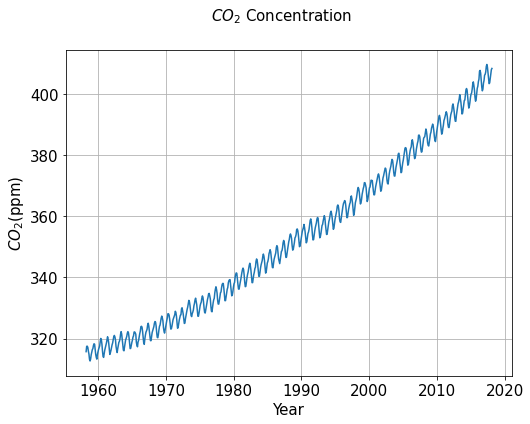

In [137]:
# plot the preliminary data
fig,ax = plt.subplots(1,figsize=(8,6))
ax.plot(dates,averages)
fig.suptitle(r'$CO_2$ Concentration',fontsize=15)
ax.set_ylabel(r'$CO_2$(ppm)',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.tick_params(axis='both',labelsize=15)
ax.grid()


We use the data before year 2010 for training the model and predict $CO_2$ concentration from 2010 to 2020 based on the model. 
It can be observed that this time series has such features:
- a long-term trend
- an annual fluctuation  

Hence we will add two components fitting with above features into the model.


In [138]:
# build up the model and feed it with the training data
train_data = tf.reshape(averages[dates<2010][:],shape=(622,))
train_dates = tf.reshape(dates[dates<2010][:],shape=(622,))

trend = tfp.sts.LocalLinearTrend(observed_time_series=train_data)
seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=train_data)
model = tfp.sts.Sum([trend, seasonal], observed_time_series=train_data)

After the feeding, we create a surrogate posterior to optimize the model.
[[reference link](https://www.tensorflow.org/probability/api_docs/python/tfp/sts/build_factored_surrogate_posterior)]

In [139]:
# minimize the loss for optimization
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model=model)
loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(train_data),
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)
posterior_samples = surrogate_posterior.sample(50)


In [140]:
# make the prediction
prediction = tfp.sts.forecast(
    model=model,
    observed_time_series=train_data,
    parameter_samples=posterior_samples,
    num_steps_forecast=len(averages)-len(train_data),
    include_observation_noise=True
)


In [141]:
co2prediction = prediction.mean().numpy()
co2error = prediction.stddev().numpy()

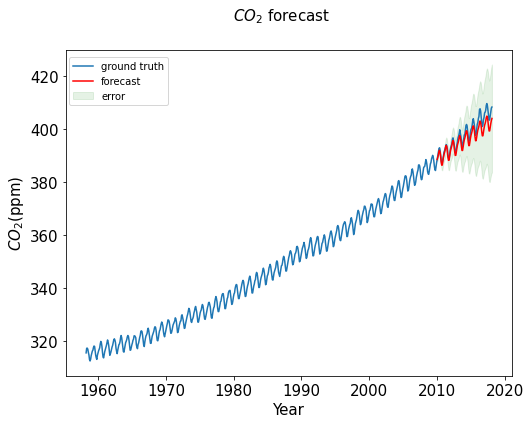

In [146]:
fig,ax = subplots(1,figsize=(8,6))
ax.plot(dates,averages,label='ground truth')
ax.plot(dates[dates>2010],co2prediction,label='forecast',color='red')
fig.suptitle(r'$CO_2$ forecast',fontsize=15)
ax.set_ylabel(r'$CO_2$(ppm)',fontsize=15)
ax.set_xlabel('Year',fontsize=15)
ax.tick_params(axis='both',labelsize=15)
ax.fill_between(dates[dates>2010],
                   (co2prediction-co2error*2)[:,0],
                   (co2prediction+co2error*2)[:,0],color='green',alpha=0.1,label='error')
fig.legend(loc=(0.13,0.75))
fig.show()


We find out that the forecast fits the data pretty well in the beginning but gets inaccurate with a larger error over time.